# Fun With Energy

### Introduction

In this notebook, we will perform simple CPU power consumption experiments on a remote Chameleon instance using `etrace2` and `stress`. We will graph the results using `matplotlib`. To perform the remote execution on the Chameleon instance, we will use the `fabric` Python package.

Before running this notebook, please configure an SSH keypair and launch an instance of the [CentOS 7 Appliance](https://www.chameleoncloud.org/appliances/1/) on [CHI @ TACC](https://chi.tacc.chameleoncloud.org) with a public floating IP.

### Imports

For those who are unfamiliar with Jupyter notebooks, `%matplotlib inline` is a Jupyter "magic command" that instructs Jupyter to render matplotlib plots embedded into the notebook.

In [1]:
%matplotlib inline

from fabric import api as fapi
from fabric import network as fnet
from fabric import state as fstate

import matplotlib.pyplot as plt

### `fabric` Configuration

`fabric` uses environment variables for connection configuration. After launching your Chameleon bare metal instance, assign your instance's floating IP to the `host_string` environment variable and the path of your SSH private key to the `key_filename` environment variable. Running this cell should produce kernel information from your Chameleon instance (if properly configured.)

In [4]:
fapi.env.user = 'cc'
fapi.env.host_string = '129.114.109.108'
fapi.env.key_filename = '~/.ssh/chameleon'
fapi.run('uname -a')

[129.114.109.108] run: uname -a
[129.114.109.108] out: Linux powertest-jchuah 3.10.0-514.2.2.el7.x86_64 #1 SMP Tue Dec 6 23:06:41 UTC 2016 x86_64 x86_64 x86_64 GNU/Linux
[129.114.109.108] out: 



'Linux powertest-jchuah 3.10.0-514.2.2.el7.x86_64 #1 SMP Tue Dec 6 23:06:41 UTC 2016 x86_64 x86_64 x86_64 GNU/Linux'

### Intercoolr `etrace2`

Intercoolr is a set of APIs that allow monitoring and controlling hardware power states on Intel Sandy Bridge (and later) processors. From this package, we will be using the `etrace2` program, which monitors power for user space programs. 

Intercoolr is available at:

[https://github.com/coolr-hpc/intercoolr](https://github.com/coolr-hpc/intercoolr)

CentOS7 comes with `etrace2` installed by default, but for our purposes we will download and compile Intercoolr.

In [24]:
fapi.run('git clone https://github.com/coolr-hpc/intercoolr.git')
fapi.run('cd intercoolr && make all')

[129.114.109.108] run: git clone https://github.com/coolr-hpc/intercoolr.git
[129.114.109.108] out: Cloning into 'intercoolr'...
[129.114.109.108] out: remote: Counting objects: 125, done.
[129.114.109.108] out: Receiving objects:   0% (1/125)   
[129.114.109.108] out: Receiving objects:   1% (2/125)   
[129.114.109.108] out: Receiving objects:   2% (3/125)   
[129.114.109.108] out: Receiving objects:   3% (4/125)   
[129.114.109.108] out: Receiving objects:   4% (5/125)   
[129.114.109.108] out: Receiving objects:   5% (7/125)   
[129.114.109.108] out: Receiving objects:   6% (8/125)   
[129.114.109.108] out: Receiving objects:   7% (9/125)   
[129.114.109.108] out: Receiving objects:   8% (10/125)   
[129.114.109.108] out: Receiving objects:   9% (12/125)   
[129.114.109.108] out: Receiving objects:  10% (13/125)   
[129.114.109.108] out: Receiving objects:  11% (14/125)   
[129.114.109.108] out: Receiving objects:  12% (15/125)   
[129.114.109.108] out: Receiving objects:  13% (17/1

'gcc -O2 -Wall -g -fopenmp   -c -o intercoolr.o intercoolr.c\r\ngcc -O2 -Wall -g -fopenmp   -c -o raplreader.o raplreader.c\r\nrm -f libintercoolr.a\r\nar cq libintercoolr.a intercoolr.o raplreader.o\r\ngcc -o measure_pstate_latency -O2 -Wall -g -fopenmp measure_pstate_latency.c -L. -lintercoolr\r\ngcc -o set_pstate -O2 -Wall -g -fopenmp set_pstate.c -L. -lintercoolr -lgomp\r\ngcc -o get_pstate -O2 -Wall -g -fopenmp get_pstate.c -L. -lintercoolr -lgomp\r\ngcc -o monitor_pstate -O2 -Wall -g -fopenmp monitor_pstate.c -L. -lintercoolr -lgomp\r\ngcc -o raplreader_test -O2 -Wall -g -fopenmp -D__TEST_MAIN__ raplreader.c \r\ngcc -o etrace2 -O2 -Wall -g -fopenmp etrace2.c raplreader.c  -lm'

### Testing `etrace2`

To test if we have properly compiled `etrace2`, we will execute it and see its command help screen.

In [25]:
print(fapi.run('./intercoolr/etrace2 -h', quiet=True))

Usage: etrace2 [options] [command]

[Options]
	-i sec : interval
	-t sec : timeout
	-o filename : output filename
	-r : relative time, instead of epoch

[usage examples]

# spawn your program and print energy consumption 
$ ./etrace2 your_program

# also print power consumption every 0.5 sec
$ ./etrace2 -i 0.5  your_program

# just print power consumption every 1sec for 10sec
$ ./etrace2 -i 1.0 -t 10


## Stress

`stress` is a workload simulator that we will use to generate a load that can be measured with `etrace2`. It is currently unavailable as a `yum` package for CentOS7, so we must download and compile it. 

`stress` is available at:

[http://people.seas.harvard.edu/~apw/stress/](http://people.seas.harvard.edu/~apw/stress/)

In [5]:
fapi.run('curl http://people.seas.harvard.edu/~apw/stress/stress-1.0.4.tar.gz | tar xz')
fapi.run('cd stress-1.0.4 && ./configure && make && sudo make install')

[129.114.109.108] run: curl http://people.seas.harvard.edu/~apw/stress/stress-1.0.4.tar.gz | tar xz
[129.114.109.108] out:   % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
[129.114.109.108] out:                                  Dload  Upload   Total   Spent    Left  Speed
[129.114.109.108] out: 
[129.114.109.108] out:   0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
[129.114.109.108] out: 100  187k  100  187k    0     0   372k      0 --:--:-- --:--:-- --:--:--  373k
[129.114.109.108] out: 

[129.114.109.108] run: cd stress-1.0.4 && ./configure && make && sudo make install
[129.114.109.108] out: checking for a BSD-compatible install... /usr/bin/install -c
[129.114.109.108] out: checking whether build environment is sane... yes
[129.114.109.108] out: checking for a thread-safe mkdir -p... /usr/bin/mkdir -p
[129.114.109.108] out: checking for gawk... gawk
[129.114.109.108] out: checking whether make sets $(MAKE)... yes
[129.114.

'checking for a BSD-compatible install... /usr/bin/install -c\r\nchecking whether build environment is sane... yes\r\nchecking for a thread-safe mkdir -p... /usr/bin/mkdir -p\r\nchecking for gawk... gawk\r\nchecking whether make sets $(MAKE)... yes\r\nchecking for gcc... gcc\r\nchecking for C compiler default output file name... a.out\r\nchecking whether the C compiler works... yes\r\nchecking whether we are cross compiling... no\r\nchecking for suffix of executables... \r\nchecking for suffix of object files... o\r\nchecking whether we are using the GNU C compiler... yes\r\nchecking whether gcc accepts -g... yes\r\nchecking for gcc option to accept ISO C89... none needed\r\nchecking for style of include used by make... GNU\r\nchecking dependency style of gcc... gcc3\r\nchecking how to run the C preprocessor... gcc -E\r\nchecking for grep that handles long lines and -e... /usr/bin/grep\r\nchecking for egrep... /usr/bin/grep -E\r\nchecking for ANSI C header files... yes\r\nchecking for 

### Testing `stress`

Once again, we will test our installation by running `stress` and viewing its help screen.

In [6]:
print(fapi.run('stress --help', quiet=True))

`stress' imposes certain types of compute stress on your system

Usage: stress [OPTION [ARG]] ...
 -?, --help         show this help statement
     --version      show version statement
 -v, --verbose      be verbose
 -q, --quiet        be quiet
 -n, --dry-run      show what would have been done
 -t, --timeout N    timeout after N seconds
     --backoff N    wait factor of N microseconds before work starts
 -c, --cpu N        spawn N workers spinning on sqrt()
 -i, --io N         spawn N workers spinning on sync()
 -m, --vm N         spawn N workers spinning on malloc()/free()
     --vm-bytes B   malloc B bytes per vm worker (default is 256MB)
     --vm-stride B  touch a byte every B bytes (default is 4096)
     --vm-hang N    sleep N secs before free (default none, 0 is inf)
     --vm-keep      redirty memory instead of freeing and reallocating
 -d, --hdd N        spawn N workers spinning on write()/unlink()
     --hdd-bytes B  write B bytes per hdd worker (default is 1GB)

Example: s

### An `etrace` function

The `etrace` function simply generates a shell command string for running `etrace`.

In [9]:
def etrace(cmd, extra=''):
    return './intercoolr/etrace2 {} {}'.format(extra, cmd)

In [10]:
cmd = etrace('sleep 5')
print(cmd)
stdout = fapi.run(cmd, quiet=True)
print(stdout)

etrace2  sleep 5
# ETRACE2_VERSION=0.1
# ELAPSED=4.990290
# ENERGY=410.191192
# ENERGY_SOCKET0=171.562549
# ENERGY_DRAM0=29.803543
# ENERGY_SOCKET1=178.981597
# ENERGY_DRAM1=30.704269


In [11]:
stdout = fapi.run(etrace('sleep 10'), quiet=True)
print(stdout)

# ETRACE2_VERSION=0.1
# ELAPSED=9.990532
# ENERGY=795.710043
# ENERGY_SOCKET0=325.826314
# ENERGY_DRAM0=59.527740
# ENERGY_SOCKET1=349.855061
# ENERGY_DRAM1=61.347798


### A `stress` function

The `stress` function generates `stress` shell command strings for running `stress` with parameters.

In [13]:
def stress(t, cpu=None, memory=None, extra=''):
    cmd = 'stress --timeout {}s'.format(t)
    if cpu:
        cmd += ' --cpu {}'.format(cpu)
    if memory:
        cmd += ' --vm {}'.format(memory)
    if extra:
        cmd += ' {}'.format(extra)
    return cmd

### `skim_trace`

This function filters `etrace` output and packages it as a Python dictionary.

In [26]:
def skim_trace(output):
    trace = {}
    other = []
    for line in output.splitlines():
        if line.startswith('# E'):
            key, value = line.split('=')
            key = key.lower().strip(' #')
            value = float(value)
            trace[key] = value
        else:
            other.append(line)
            
    return trace, '\n'.join(other)

In [27]:
cmd = etrace(stress(5, 48))
print(cmd)
stdout = fapi.run(cmd, quiet=True)
trace, remainder = skim_trace(stdout)
print(remainder)
trace

etrace2  stress --timeout 5s --cpu 48
stress: info: [13402] dispatching hogs: 48 cpu, 0 io, 0 vm, 0 hdd
stress: info: [13402] successful run completed in 5s


{'elapsed': 4.992395,
 'energy': 1006.681409,
 'energy_dram0': 29.83448,
 'energy_dram1': 30.823334,
 'energy_socket0': 458.666917,
 'energy_socket1': 488.223787,
 'etrace2_version': 0.1}

In [16]:
cmd = etrace(stress(5, memory=4))
print(cmd)
stdout = fapi.run(cmd, quiet=True)
skim_trace(stdout)[0]

etrace2  stress --timeout 5s --vm 4


{'elapsed': 4.991439,
 'energy': 555.633497,
 'energy_dram0': 38.155767,
 'energy_dram1': 56.365736,
 'energy_socket0': 199.25834,
 'energy_socket1': 262.752562,
 'etrace2_version': 0.1}

### Generating and plotting data

We will now generate a series of measurements.

In [17]:
runs = []
t = 5
for n_cpu in [0, 1, 2, 6, 12, 18, 24, 36, 48, 60]:
    if n_cpu > 0:
        cmd = stress(t, n_cpu)
    else:
        cmd = 'sleep {}'.format(t)
    stdout = fapi.run(etrace(cmd), quiet=True)
    trace, _ = skim_trace(stdout)
    trace['n_cpu'] = n_cpu
    runs.append(trace)
    
print runs

Now we can plot the power use in Watts of each run.

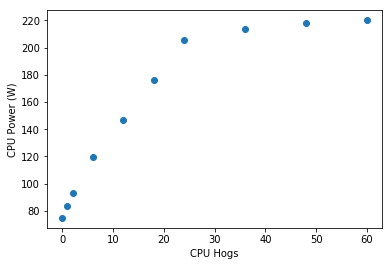

In [16]:
def socket_power(run):
    return (run['energy_socket0'] + run['energy_socket1']) / run['elapsed']

f, ax = plt.subplots()
workers, sockets_power = zip(*((r['n_cpu'], socket_power(r)) for r in runs))
ax.plot(workers, sockets_power, 'o')
ax.set_xlabel('CPU Hogs')
ax.set_ylabel('CPU Power (W)')

### `etrace` time series data

By specifying the `-i 0.25` switch for `etrace2`, we can get time series data for the individual runs.

In [31]:
runs = {}
for n_cpu in [1, 6, 24, 100]:
    runs[n_cpu] = fapi.run(etrace(stress(10, n_cpu), extra='-i 0.25'), quiet=True)

In [32]:
def extract_values(out):
    points = []
    for line in out.splitlines():
        try:
            values = [float(x) for x in line.split()]
        except ValueError:
            continue
        if len(values) != 3:
            continue
        points.append(values)
    return points

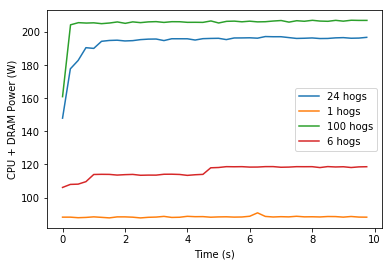

In [35]:
f, ax = plt.subplots()

for n_cpu, run in runs.items():
    time_points = extract_values(run)
    t, p, e = zip(*time_points)
    trel = [tx - t[0] for tx in t]
    
    ax.plot(trel, p, label='{} hogs'.format(n_cpu))
    
ax.set_xlabel('Time (s)')
ax.set_ylabel('CPU + DRAM Power (W)')
ax.legend()
plt.show()

### Disconecting `fabric`

Finally, we can terminate our SSH session through `fabric`.

In [20]:
fnet.disconnect_all()

Disconnecting from 129.114.109.207... done.
